<p style="align: center;"><img src="https://raw.githubusercontent.com/dimkablin/SegmentationSM/master/src/logo2.jpg", width=550, height=300></p>

<h1 style="text-align: center;"><b>Backend SM</b></h1>
<h2 style="text-align: center;"><b>Поиск архитекутуры для сегментации объекта для проекта SM </b></h2>

In [1]:
import os
from LookGenerator.config.config import DatasetConfig

config = DatasetConfig(os.environ)
config.show_details()

DATASET_DIR
BACKGROUND_DATASET


In [2]:
print(config.BACKGROUND_DATASET, "--", config.DATASET_DIR)

 -- C:\Users\dimka\PycharmProjects\data\zalando-hd-resized\


## Инициализируем датасет и dataloader

In [1]:
from torchvision.transforms import ToTensor, ToPILImage, PILToTensor
import torch
from torch.utils.data import DataLoader
import os
import numpy as np
from typing import Tuple
import cv2
import random

from PIL import Image
from torch.utils.data import Dataset
from LookGenerator.datasets.person_segmentation_dataset import PersonSegmentationDataset
from LookGenerator.networks.segmentation import UNet
import albumentations
import torchvision.transforms as transforms
import LookGenerator.datasets.transforms as custom_transforms
from LookGenerator.networks.losses import FocalLossBin
from LookGenerator.networks.trainer import Trainer
from LookGenerator.networks_training.utils import check_path_and_creat

Напишем датасет, который будет в себе хранить названия всех файлов и загружать их в методе \_\_getitem__()

Передадим ему путь к исходным фотографиям X и маске Y

In [2]:
transform_input = transforms.Compose([
    transforms.Resize((256, 192)),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.25, 0.25, 0.25]
    )
])

transform_output = transforms.Compose([
    transforms.Resize((256, 192)),
    custom_transforms.MinMaxScale(),
    custom_transforms.ThresholdTransform(threshold=0.5)
])

In [3]:
# transform_image = albumentations.Compose([
#         albumentations.Resize(height=256, width=192),
#         albumentations.RandomBrightnessContrast(brightness_limit=(0.1,0.3), contrast_limit=(0.2,0.7), p =0.2),
#         albumentations.Equalize(p = 0.2),
#         albumentations.GaussNoise(p = 0.2),
#         albumentations.Affine(translate_percent=0.1, scale=(0.8, 1), rotate=(-90,90), p=0.2),
#         albumentations.Normalize(mean = (0.5, 0.5, 0.5), std = (0.25, 0.25, 0.25)),
#     ])
#
# transform_mask = albumentations.Compose([
#         albumentations.Resize(height=256, width=192),
#         albumentations.Normalize(mean = (0.5, 0.5, 0.5), std = (0.25, 0.25, 0.25)),
#     ])

In [4]:
transform_train = albumentations.Compose([
        albumentations.Resize(height=256, width=192),
        albumentations.RandomBrightnessContrast(brightness_limit=(0.1,0.3), contrast_limit=(0.2,0.7), p =0.2),
        albumentations.Equalize(p = 0.2),
        albumentations.GaussNoise(p = 0.2),
        albumentations.Affine(translate_percent=0.1, scale=(0.8, 1), rotate=(-90,90), p=0.2),
        albumentations.Normalize(mean = (0.5, 0.5, 0.5), std = (0.25, 0.25, 0.25)),
    ])

transform_valid = albumentations.Compose([
        albumentations.Resize(height=256, width=192),
        albumentations.Normalize(mean = (0.5, 0.5, 0.5), std = (0.25, 0.25, 0.25)),
    ])

In [5]:
# train_dataset = OblDataset(image_root=os.path.join(r"C:\Users\DenisovDmitrii\Desktop\zalando-hd-resize", "train", "image"),
#                            mask_root=os.path.join(r"C:\Users\DenisovDmitrii\Desktop\zalando-hd-resize", "train", "agnostic-v3.3"),
#                            mask_layer=128,
#                            image_extension="jpg",
#                            transform_input=transform_input,
#                            transform_output=transform_output)
#
# val_dataset = OblDataset(image_root=os.path.join(r"C:\Users\DenisovDmitrii\Desktop\zalando-hd-resize", "test", "image"),
#                          mask_root=os.path.join(r"C:\Users\DenisovDmitrii\Desktop\zalando-hd-resize", "test", "agnostic-v3.3"),
#                          mask_layer=128,
#                          image_extension="jpg",
#                          transform_input=transform_input,
#                          transform_output=transform_output)

In [6]:
train_dataset = PersonSegmentationDataset(r"C:\Users\DenisovDmitrii\Desktop\zalando-hd-resize\train", augment=transform_train)


In [7]:
val_dataset = PersonSegmentationDataset(r"C:\Users\DenisovDmitrii\Desktop\zalando-hd-resize\test", augment=transform_valid)


Проверим его корректность работы и выведем парочку

In [8]:
import matplotlib.pyplot as plt

def _print(image, mask):
    fig = plt.figure(figsize=(20, 14))

    fig.add_subplot( 1, 2, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))

    fig.add_subplot( 1, 2, 2)
    plt.imshow(mask[0], cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 192]) torch.Size([1, 256, 192]) 5408


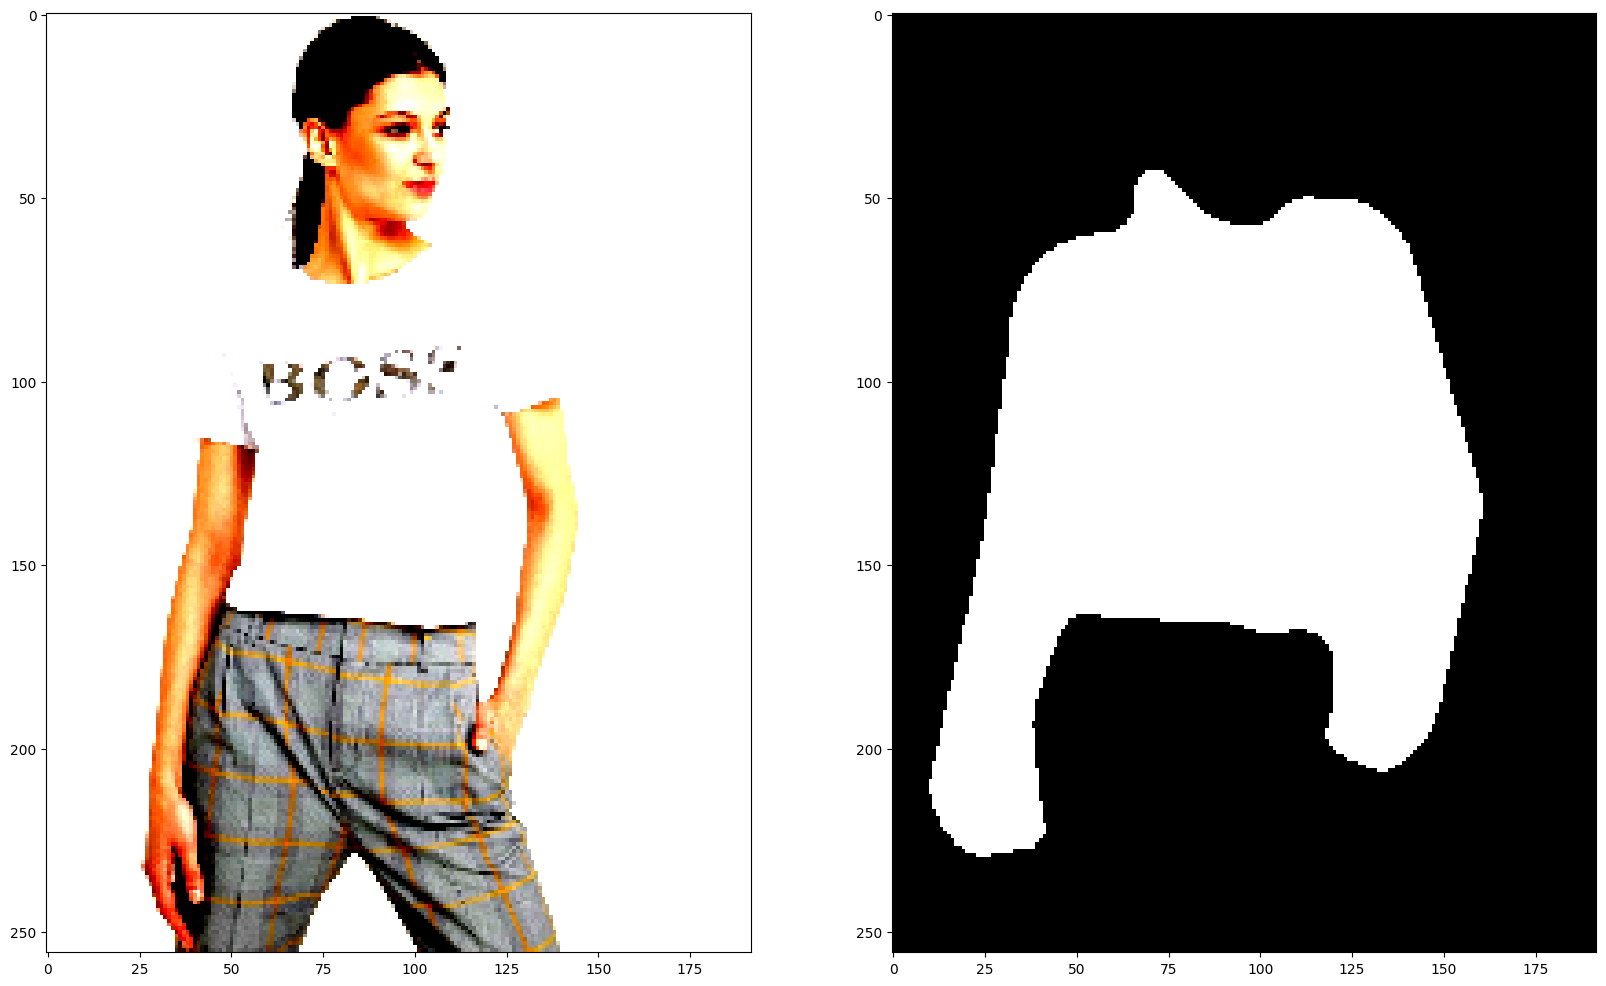

In [9]:
number = np.random.randint(0, 11647)


image, mask = train_dataset.__getitem__(number)
print(image.shape, mask.shape, number)
_print(image, mask)


Поделим датасет на тренировочную, валидационную и тестовую

In [10]:
batch_size_train = 32 * 2
batch_size_val = 16 * 2
pin_memory = True
num_workers = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=pin_memory, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False, pin_memory=pin_memory, num_workers=num_workers)


## Реализируем основной цикл обучения

# Обучение

## Architectures
### 1. our Unet

In [11]:
model_unet = UNet(in_channels=3, out_channels = 1)

In [12]:
#model = load_model(model, r'')                 # активировать, если модель надо загрузить и дообучить
optimizer = torch.optim.Adam(model_unet.parameters(), lr = 1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = FocalLossBin()
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True

In [15]:
save_directory = r"C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\segmetationBackground\weights\testResults"
check_path_and_creat(save_directory)


True

In [16]:
epoch_num = 30

In [17]:
trainer = Trainer(
    model_=model_unet, optimizer=optimizer, criterion = criterion,
    device=device, save_directory=save_directory, save_step=1, verbose=True
)

In [18]:
trainer.train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, epoch_num=epoch_num)

start time 20-05-2023 19:46


100%|██████████| 364/364 [02:46<00:00,  2.19it/s]


Epoch 0 of 29, train loss: 0.01239
Epoch end time 20-05-2023 19:49


100%|██████████| 127/127 [00:11<00:00, 11.32it/s]


Epoch 0 of 29, val loss: 0.00232
Epoch end time 20-05-2023 19:49


100%|██████████| 364/364 [01:59<00:00,  3.05it/s]


Epoch 1 of 29, train loss: 0.00225
Epoch end time 20-05-2023 19:51


100%|██████████| 127/127 [00:09<00:00, 13.19it/s]


Epoch 1 of 29, val loss: 0.00124
Epoch end time 20-05-2023 19:51


100%|██████████| 364/364 [01:58<00:00,  3.07it/s]


Epoch 2 of 29, train loss: 0.00137
Epoch end time 20-05-2023 19:53


100%|██████████| 127/127 [00:09<00:00, 13.39it/s]


Epoch 2 of 29, val loss: 0.00121
Epoch end time 20-05-2023 19:53


100%|██████████| 364/364 [01:56<00:00,  3.12it/s]


Epoch 3 of 29, train loss: 0.00110
Epoch end time 20-05-2023 19:55


100%|██████████| 127/127 [00:11<00:00, 10.96it/s]


Epoch 3 of 29, val loss: 0.00071
Epoch end time 20-05-2023 19:55


100%|██████████| 364/364 [01:59<00:00,  3.04it/s]


Epoch 4 of 29, train loss: 0.00084
Epoch end time 20-05-2023 19:57


100%|██████████| 127/127 [00:09<00:00, 13.46it/s]


Epoch 4 of 29, val loss: 0.00066
Epoch end time 20-05-2023 19:57


100%|██████████| 364/364 [01:55<00:00,  3.15it/s]


Epoch 5 of 29, train loss: 0.00077
Epoch end time 20-05-2023 19:59


100%|██████████| 127/127 [00:09<00:00, 13.61it/s]


Epoch 5 of 29, val loss: 0.00062
Epoch end time 20-05-2023 19:59


100%|██████████| 364/364 [01:55<00:00,  3.15it/s]


Epoch 6 of 29, train loss: 0.00068
Epoch end time 20-05-2023 20:01


100%|██████████| 127/127 [00:09<00:00, 13.67it/s]


Epoch 6 of 29, val loss: 0.00049
Epoch end time 20-05-2023 20:01


100%|██████████| 364/364 [01:55<00:00,  3.15it/s]


Epoch 7 of 29, train loss: 0.00064
Epoch end time 20-05-2023 20:03


100%|██████████| 127/127 [00:09<00:00, 13.69it/s]


Epoch 7 of 29, val loss: 0.00041
Epoch end time 20-05-2023 20:04


100%|██████████| 364/364 [01:54<00:00,  3.18it/s]


Epoch 8 of 29, train loss: 0.00053
Epoch end time 20-05-2023 20:05


100%|██████████| 127/127 [00:09<00:00, 13.72it/s]


Epoch 8 of 29, val loss: 0.00045
Epoch end time 20-05-2023 20:06


100%|██████████| 364/364 [01:54<00:00,  3.19it/s]


Epoch 9 of 29, train loss: 0.00052
Epoch end time 20-05-2023 20:08


100%|██████████| 127/127 [00:09<00:00, 13.70it/s]


Epoch 9 of 29, val loss: 0.00043
Epoch end time 20-05-2023 20:08


100%|██████████| 364/364 [01:54<00:00,  3.19it/s]


Epoch 10 of 29, train loss: 0.00047
Epoch end time 20-05-2023 20:10


100%|██████████| 127/127 [00:09<00:00, 13.70it/s]


Epoch 10 of 29, val loss: 0.00038
Epoch end time 20-05-2023 20:10


100%|██████████| 364/364 [01:54<00:00,  3.19it/s]


Epoch 11 of 29, train loss: 0.00042
Epoch end time 20-05-2023 20:12


100%|██████████| 127/127 [00:09<00:00, 13.68it/s]


Epoch 11 of 29, val loss: 0.00041
Epoch end time 20-05-2023 20:12


100%|██████████| 364/364 [01:54<00:00,  3.19it/s]


Epoch 12 of 29, train loss: 0.00041
Epoch end time 20-05-2023 20:14


100%|██████████| 127/127 [00:09<00:00, 13.73it/s]


Epoch 12 of 29, val loss: 0.00040
Epoch end time 20-05-2023 20:14


100%|██████████| 364/364 [01:52<00:00,  3.24it/s]


Epoch 13 of 29, train loss: 0.00038
Epoch end time 20-05-2023 20:16


100%|██████████| 127/127 [00:09<00:00, 13.41it/s]


Epoch 13 of 29, val loss: 0.00037
Epoch end time 20-05-2023 20:16


100%|██████████| 364/364 [01:52<00:00,  3.24it/s]


Epoch 14 of 29, train loss: 0.00037
Epoch end time 20-05-2023 20:18


100%|██████████| 127/127 [00:09<00:00, 14.00it/s]


Epoch 14 of 29, val loss: 0.00035
Epoch end time 20-05-2023 20:18


100%|██████████| 364/364 [01:52<00:00,  3.25it/s]


Epoch 15 of 29, train loss: 0.00035
Epoch end time 20-05-2023 20:20


100%|██████████| 127/127 [00:09<00:00, 14.02it/s]


Epoch 15 of 29, val loss: 0.00030
Epoch end time 20-05-2023 20:20


100%|██████████| 364/364 [01:52<00:00,  3.25it/s]


Epoch 16 of 29, train loss: 0.00031
Epoch end time 20-05-2023 20:22


100%|██████████| 127/127 [00:09<00:00, 13.95it/s]


Epoch 16 of 29, val loss: 0.00030
Epoch end time 20-05-2023 20:22


100%|██████████| 364/364 [01:52<00:00,  3.25it/s]


Epoch 17 of 29, train loss: 0.00031
Epoch end time 20-05-2023 20:24


100%|██████████| 127/127 [00:09<00:00, 14.04it/s]


Epoch 17 of 29, val loss: 0.00035
Epoch end time 20-05-2023 20:24


100%|██████████| 364/364 [01:52<00:00,  3.25it/s]


Epoch 18 of 29, train loss: 0.00031
Epoch end time 20-05-2023 20:26


100%|██████████| 127/127 [00:09<00:00, 13.97it/s]


Epoch 18 of 29, val loss: 0.00035
Epoch end time 20-05-2023 20:26


100%|██████████| 364/364 [01:52<00:00,  3.25it/s]


Epoch 19 of 29, train loss: 0.00029
Epoch end time 20-05-2023 20:28


100%|██████████| 127/127 [00:09<00:00, 13.94it/s]


Epoch 19 of 29, val loss: 0.00029
Epoch end time 20-05-2023 20:28


100%|██████████| 364/364 [01:51<00:00,  3.25it/s]


Epoch 20 of 29, train loss: 0.00024
Epoch end time 20-05-2023 20:30


100%|██████████| 127/127 [00:09<00:00, 13.99it/s]


Epoch 20 of 29, val loss: 0.00035
Epoch end time 20-05-2023 20:30


100%|██████████| 364/364 [01:52<00:00,  3.25it/s]


Epoch 21 of 29, train loss: 0.00024
Epoch end time 20-05-2023 20:32


100%|██████████| 127/127 [00:09<00:00, 14.11it/s]


Epoch 21 of 29, val loss: 0.00031
Epoch end time 20-05-2023 20:32


100%|██████████| 364/364 [01:52<00:00,  3.25it/s]


Epoch 22 of 29, train loss: 0.00022
Epoch end time 20-05-2023 20:34


100%|██████████| 127/127 [00:09<00:00, 14.01it/s]


Epoch 22 of 29, val loss: 0.00032
Epoch end time 20-05-2023 20:34


100%|██████████| 364/364 [01:51<00:00,  3.25it/s]


Epoch 23 of 29, train loss: 0.00022
Epoch end time 20-05-2023 20:36


100%|██████████| 127/127 [00:09<00:00, 13.97it/s]


Epoch 23 of 29, val loss: 0.00029
Epoch end time 20-05-2023 20:36


100%|██████████| 364/364 [01:52<00:00,  3.25it/s]


Epoch 24 of 29, train loss: 0.00022
Epoch end time 20-05-2023 20:38


100%|██████████| 127/127 [00:09<00:00, 14.01it/s]


Epoch 24 of 29, val loss: 0.00033
Epoch end time 20-05-2023 20:38


100%|██████████| 364/364 [01:53<00:00,  3.22it/s]


Epoch 25 of 29, train loss: 0.00022
Epoch end time 20-05-2023 20:40


100%|██████████| 127/127 [00:09<00:00, 14.04it/s]


Epoch 25 of 29, val loss: 0.00025
Epoch end time 20-05-2023 20:40


100%|██████████| 364/364 [01:53<00:00,  3.20it/s]


Epoch 26 of 29, train loss: 0.00020
Epoch end time 20-05-2023 20:42


100%|██████████| 127/127 [00:09<00:00, 13.93it/s]


Epoch 26 of 29, val loss: 0.00026
Epoch end time 20-05-2023 20:42


100%|██████████| 364/364 [01:53<00:00,  3.20it/s]


Epoch 27 of 29, train loss: 0.00016
Epoch end time 20-05-2023 20:44


100%|██████████| 127/127 [00:09<00:00, 13.97it/s]


Epoch 27 of 29, val loss: 0.00030
Epoch end time 20-05-2023 20:44


100%|██████████| 364/364 [01:53<00:00,  3.20it/s]


Epoch 28 of 29, train loss: 0.00017
Epoch end time 20-05-2023 20:46


100%|██████████| 127/127 [00:09<00:00, 14.04it/s]


Epoch 28 of 29, val loss: 0.00029
Epoch end time 20-05-2023 20:46


100%|██████████| 364/364 [01:52<00:00,  3.25it/s]


Epoch 29 of 29, train loss: 0.00015
Epoch end time 20-05-2023 20:48


100%|██████████| 127/127 [00:08<00:00, 14.17it/s]

Epoch 29 of 29, val loss: 0.00028
Epoch end time 20-05-2023 20:48
end time 20-05-2023 20:48
delta 1:02:35.598464


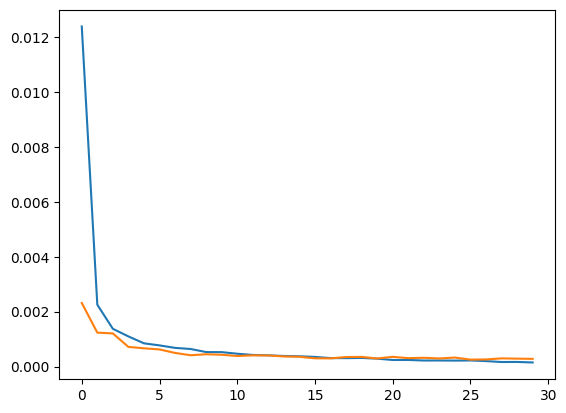

In [19]:
trainer.draw_history_plots()

In [20]:
from LookGenerator.networks.losses import IoUMetricBin
iou_sum = 0
metric = IoUMetricBin()
model_unet.eval()
model_unet.to(device)
for image, mask in val_dataloader:
     image = image.to(device)
     mask = mask.to(device)
     output = model_unet(image)
     iou_sum += metric(output, mask).item()

iou_sum / len(val_dataloader)

0.9055584063680153

### Визуальная проверка результатов

In [15]:
def check_losses(model_, dataloader_, **loss_fns_):
    model_.eval()

    losses = { key : 0 for key in loss_fns_.keys() }

    for x_batch, y_batch in dataloader_:
        y_pred = model_(x_batch)

        for name, loss_fn in loss_fns_.items():
            loss = loss_fn(y_batch, y_pred)
            losses[name] += loss.item() * len(x_batch)

    for name, loss in losses.item():
        losses[name] /= len(dataloader_)

    return losses

def plot_results(model_, dataloader_):
    for x_batch, y_batch in dataloader_:
        y_hat = model_(x_batch)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(x_batch[k].cpu().numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(y_hat[k, 0], cmap='gray')
            plt.title('output')
            plt.axis('off')
        plt.show()
        break

## 2. a few Unet's arhc

In [13]:
model_unet2 = UNet(in_channels=3, out_channels=1, features=(64, 128, 256))
optimizer = torch.optim.Adam(model_unet2.parameters(), lr=1e-3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = FocalLossBin()
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.benchmark = True

In [20]:
save_directory = r"C:\Users\DenisovDmitrii\OneDrive - ITMO UNIVERSITY\peopleDetector\segmetationBackground\weights\testResultsFeatures_32_64_128_256"
check_path_and_creat(save_directory)

True

In [ ]:
epoch_num = 30
trainer = Trainer(
    model_=model_unet2, optimizer=optimizer, criterion=criterion,
    device=device, save_directory=save_directory, save_step=1, verbose=True
)
trainer.train(train_dataloader=train_dataloader, val_dataloader=val_dataloader, epoch_num=epoch_num)

In [ ]:
trainer.draw_history_plots()

In [ ]:
from LookGenerator.networks.losses import IoUMetricBin
iou_sum = 0
metric = IoUMetricBin()
model_unet2.eval()
model_unet2.to(device)
for image, mask in val_dataloader:
     image = image.to(device)
     mask = mask.to(device)
     output = model_unet2(image)
     iou_sum += metric(output, mask).item()

iou_sum / len(val_dataloader)

In [ ]:
from torchsummary import summary
summary(model_unet2.to('cuda'), (3, 256, 192))
